#

# South African Language Identification Hackathon

### overview

South Africa boasts a vibrant multicultural society, celebrated for its rich linguistic tapestry. Language serves as a vital instrument for enhancing democracy and enriching various facets of South African life, including social, cultural, intellectual, economic, and political spheres.

With 11 official languages, each granted equal status, South Africa is truly multilingual. The majority of South Africans are proficient in multiple languages, reflecting the nation's linguistic diversity and inclusivity.

Given this diverse linguistic landscape, our systems and devices are designed to communicate effectively across multiple languages.

In this challenge, I am challenged for identifying the language of a given text, which could be in any of South Africa's 11 official languages. This task aligns with the field of Natural Language Processing (NLP) and involves determining the language in which a piece of text is written.

### Import needed Libraries

In [8]:
import re
import string
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score
import numpy as np
import nltk


#Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Models
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer



### Load Dataset

In [56]:
data=pd.read_csv(r"C:\Users\Lindelani\Downloads\south-african-language-identification-hack-2023\train_set.csv", encoding='UTF-8')
test= pd.read_csv(r"C:\Users\Lindelani\Downloads\south-african-language-identification-hack-2023\test_set.csv" ,encoding='UTF-8')

#Insurance Dataset
data_copy = data.copy()

In [58]:
data.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [60]:
test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


### Data Preprocessing

In [59]:
data.describe()

,lang_id,text
count,33000,33000
unique,11,29948
top,xho,ngokwesekhtjheni yomthetho ophathelene nalokhu...
freq,3000,17


In [6]:
#Character Length
data_copy['length'] = data_copy['text'].apply(lambda x: len(x))

In [7]:
data.describe()

,lang_id,text
count,33000,33000
unique,11,29948
top,xho,ngokwesekhtjheni yomthetho ophathelene nalokhu...
freq,3000,17


###

### Data cleaning

The below code is applying techniques to clean the data

In [8]:
#Remove Punctuations
def _remove_punc(x):
    """
    Func removes punctuation and ASCII character
    using string.punctuation function
    
    Args:
        data: pandas dataframe
    Return:
        Dataframe: clean tweets
    """
    x = re.sub(r'[-]',' ',x)
    x = re.sub(r'[_]', ' ', x)
    x = re.sub(r'[^\w\s]','',x)
    x = re.sub('[0-9]+', '', x)
    x = re.sub(r'[^\x00-\x7f]',r'', x)
    return x
#Apply the function to the dataset
data_copy['clean_punc'] = data_copy['text'].apply(_remove_punc)

re.sub(r'[-]',' ',x): This line replaces hyphens with a space. For example, it would convert "hello-world" to "hello world".

re.sub(r'[_]', ' ', x): This line replaces underscores with a space. For example, it would convert "hello_world" to "hello world".

re.sub(r'[^\w\s]','',x): This line removes any character that is not a word character (alphanumeric) or whitespace. The pattern [^\w\s] matches any character that is not a word character (a-z, A-Z, 0-9, and underscore) or whitespace and replaces it with an empty string, effectively removing it from the text.

re.sub('[0-9]+', '', x): This line removes any sequence of digits (numbers) from the text. For example, it would convert "hello123world456" to "helloworld".

re.sub(r'[^\x00-\x7f]',r'', x): This line removes non-ASCII characters from the text. The pattern [^\x00-\x7f] matches any character that is not within the ASCII range (0-127) and replaces it with an empty string.

In [9]:
def _lower(x):
    return x.lower()
data_copy['lower'] = data_copy['clean_punc'].apply(_lower)

In [10]:
from nlppreprocess import NLP
nlp = NLP()
nlp.process('couldnt')

'could not'

In [5]:
import nltk


In [12]:
#Remove Stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(x):
    """
    Remove stop-word in the dataset to reduce noise
    Args:
        Args:
        data: pandas dataframe
    Return:
        Dataframe:non-stop word
    """
    stopwords = NLP(replace_words=True, remove_stopwords=True, 
                            remove_numbers=True, remove_punctuations=False) 
    x = stopwords.process(x)
    return x
    
data_copy['Text_nonstop'] = data_copy['lower'].apply(lambda x: remove_stopwords(x))

In [13]:
def _analyzer (x):
    """
    Function combines all the cleaning operations
    """
    x = _remove_punc(x)
    x = _lower(x)
    x = remove_stopwords(x)
    return x

In [14]:
data_copy.head()

,lang_id,text,length,clean_punc,lower,Text_nonstop
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,220,umgaqo siseko wenza amalungiselelo kumaziko ax...,umgaqo siseko wenza amalungiselelo kumaziko ax...,umgaqo siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,252,i dha iya kuba nobulumko bokubeka umsebenzi na...,i dha iya kuba nobulumko bokubeka umsebenzi na...,dha iya kuba nobulumko bokubeka umsebenzi naph...
2,eng,the province of kwazulu-natal department of tr...,264,the province of kwazulu natal department of tr...,the province of kwazulu natal department of tr...,province kwazulu natal department transport in...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,217,o netefata gore o ba file dilo ka moka te le d...,o netefata gore o ba file dilo ka moka te le d...,o netefata gore o ba file dilo ka moka te le d...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,239,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...


## Exploration Data Analysis (EDA)

In [65]:
pd.DataFrame(data['lang_id'].value_counts())

,count
lang_id,
xho,3000
eng,3000
nso,3000
ven,3000
tsn,3000
nbl,3000
zul,3000
ssw,3000
tso,3000


 ## Bar plot represanting distribution of languages

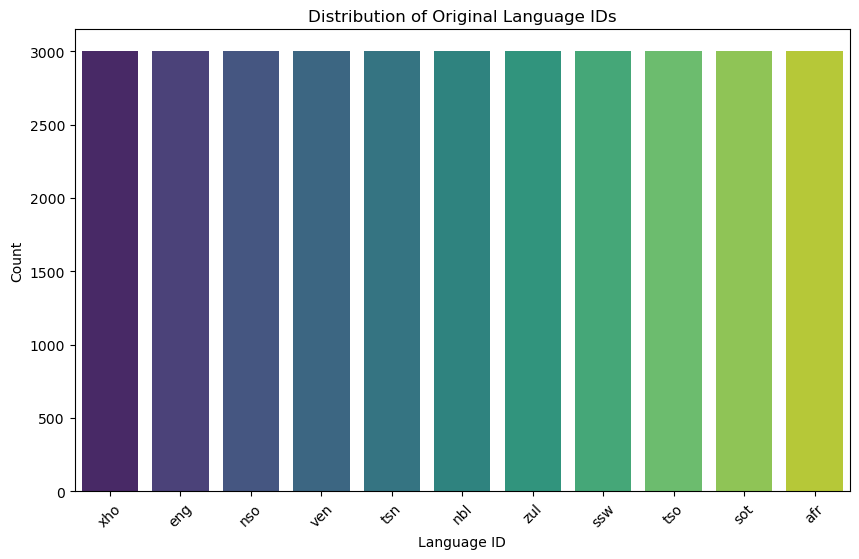

In [63]:
original_lang_id_counts =data['lang_id'].value_counts()

# Create bar plot for original data
plt.figure(figsize=(10, 6))
sns.barplot(x=original_lang_id_counts.index, y=original_lang_id_counts.values, palette='viridis')
plt.title('Distribution of Original Language IDs')
plt.xlabel('Language ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

base on the above observation  we can conclude that South African languages are equally distributed

## World Cloud

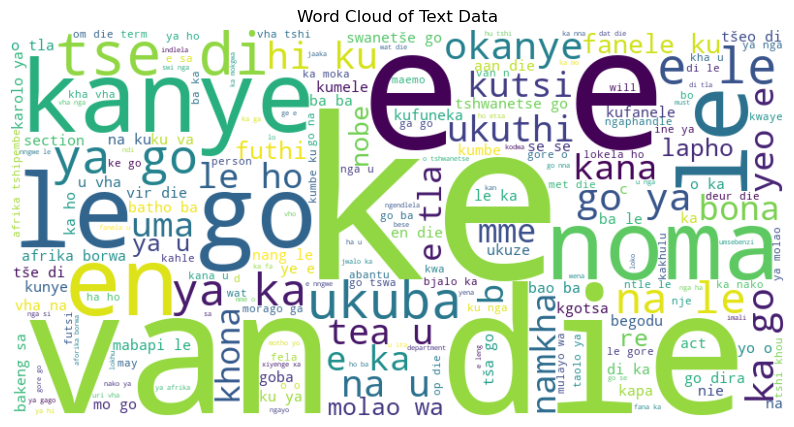

In [66]:
all_text = ' '.join(data['text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Text Data')
plt.axis('off')
plt.show()

The plot above highlights the most prominently displayed text.

## Feature Text Engineering

In [4]:
data['cleaned'] = data['text'].apply(_analyzer)
test['cleaned'] = test['text'].apply(_analyzer)

In [16]:
# Splitting  X (indepedent) and Y (target/dependent) variables
X = data['cleaned']
y = data['lang_id']

### Train Test Split

In [18]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y, stratify=y,
                                                       test_size =0.4, 
                                                       random_state=42)

# 

# Modelling

In [20]:
alg = [LogisticRegression(random_state =42 , max_iter=5000) , 
       MultinomialNB(), LinearSVC(random_state=42), 
       SGDClassifier(random_state=42), RidgeClassifier(random_state=42)]

In [22]:
def _performace_assesment(*args , **kwargs):
  model_stats = {}
  for clf in alg:
    model = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(1, 5), analyzer= 'char')),
                      ('clf' , clf)
                      ])
    
    model.fit(X_train, y_train) #Training
    model_pred = model.predict(X_test) #Testing

    # Dictionary of Models Performances
    model_stats[clf.__class__.__name__] = {
        'F1-Macro':metrics.f1_score(y_test, model_pred, average='macro'),
        'F1-Accuracy':metrics.f1_score(y_test, model_pred, average='micro'),
        'F1-Weighted':metrics.f1_score(y_test, model_pred, average='weighted')}
  return pd.DataFrame.from_dict(model_stats, orient='index')


In [23]:
performance = _performace_assesment(alg , X_train , X_test , y_train , y_test)
performance.to_csv('performance.csv')
dataframe = pd.read_csv('performance.csv', index_col = 0)
dataframe.sort_values('F1-Weighted', ascending=False)

C:\Users\Lindelani\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
C:\Users\Lindelani\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
C:\Users\Lindelani\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
C:\Users\Lindelani\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Lindelani\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:547: UserWarning: Th

,F1-Macro,F1-Accuracy,F1-Weighted
MultinomialNB,0.999394,0.999394,0.999394
RidgeClassifier,0.999167,0.999167,0.999167
LinearSVC,0.999167,0.999167,0.999167
SGDClassifier,0.999091,0.999091,0.999091
LogisticRegression,0.998031,0.998030,0.998031


## Hyperparameter Tuning

In [24]:
def _param_tuning(*args , **kwargs):
  best_params = {}

  for clf in alg:
    model = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(1, 5), analyzer= 'char')),
                      ('clf' , clf)])
    model.fit(X_train, y_train) #Training
    
    #Get models performing parameters
    params = model.get_params()
    model_name = clf.__class__.__name__ 
    model_name = {}
    for key in params:
      if key.startswith("clf"):
        if len(key) < 5:
          model_name['model'] = params[key]
        else:
            model_name[key[5:]] = params[key]
    best_params[clf.__class__.__name__] = model_name
  return best_params

In [25]:
best_params = _param_tuning(alg, X_train, y_train)

C:\Users\Lindelani\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
C:\Users\Lindelani\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
C:\Users\Lindelani\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
C:\Users\Lindelani\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Lindelani\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:547: UserWarning: Th

In [26]:
#Best parameters
best_params

{'LogisticRegression': {'model': LogisticRegression(max_iter=5000, random_state=42),
  'C': 1.0,
  'class_weight': None,
  'dual': False,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'l1_ratio': None,
  'max_iter': 5000,
  'multi_class': 'auto',
  'n_jobs': None,
  'penalty': 'l2',
  'random_state': 42,
  'solver': 'lbfgs',
  'tol': 0.0001,
  'verbose': 0,
  'warm_start': False},
 'MultinomialNB': {'model': MultinomialNB(),
  'alpha': 1.0,
  'class_prior': None,
  'fit_prior': True,
  'force_alpha': True},
 'LinearSVC': {'model': LinearSVC(random_state=42),
  'C': 1.0,
  'class_weight': None,
  'dual': 'warn',
  'fit_intercept': True,
  'intercept_scaling': 1,
  'loss': 'squared_hinge',
  'max_iter': 1000,
  'multi_class': 'ovr',
  'penalty': 'l2',
  'random_state': 42,
  'tol': 0.0001,
  'verbose': 0},
 'SGDClassifier': {'model': SGDClassifier(random_state=42),
  'alpha': 0.0001,
  'average': False,
  'class_weight': None,
  'early_stopping': False,
  'epsilon': 0.1,
  'eta0':

### GridSearchCV

#### Applying MultinomialNB()

In [ ]:

model1 = MultinomialNB()

In [28]:
Vectorize = TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(1, 5), analyzer= 'char')
X_train = Vectorize.fit_transform(X_train)
X_test = Vectorize.transform(X_test)

C:\Users\Lindelani\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [29]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True,
                                   random_state=42)

In [30]:
best_params[alg[1].__class__.__name__]

{'model': MultinomialNB(),
 'alpha': 1.0,
 'class_prior': None,
 'fit_prior': True,
 'force_alpha': True}

In [31]:
alpha = list(np.linspace(0.1,0.02,4))
param_grid = dict(alpha=alpha)
grid_search = GridSearchCV(estimator= model1,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [32]:
grid_search.fit(X_train, y_train)
prediction = grid_search.predict(X_test)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)

In [33]:
print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')
grid_search.best_params_    
grid_search.best_estimator_

Cross-validation score: 0.9996969686252897
Test score: 0.9995455174533855


MultinomialNB(alpha=0.04666666666666667)

#### RidgeRegression

In [2]:

model2 = RidgeClassifier()

In [35]:
best_params[alg[4].__class__.__name__]

{'model': RidgeClassifier(random_state=42),
 'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': 42,
 'solver': 'auto',
 'tol': 0.0001}

In [36]:
alpha = list(np.linspace(0.15,0.4, 5))
param_grid = dict(alpha=alpha)
grid_search = GridSearchCV(estimator= model2,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [37]:
grid_search.fit(X_train, y_train)
prediction = grid_search.predict(X_test)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)

In [38]:
print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')
grid_search.best_params_    
grid_search.best_estimator_

Cross-validation score: 0.9994949477404799
Test score: 0.9990909717224429


RidgeClassifier(alpha=0.275)

In [39]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline


In [41]:
X_train , X_test , y_train , y_test = train_test_split(X, y,  stratify=y, test_size=0.4, random_state =1)

In [42]:
vect = TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(2, 6), analyzer= 'char')
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

C:\Users\Lindelani\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [43]:
multiNB1 = MultinomialNB(alpha=0.1)
multiNB2 = MultinomialNB(alpha=0.1)

estimators = [('multiNB1', multiNB1), ('multiNB2', multiNB2)]
final_est = RidgeClassifier(alpha=0.2125)

###

### stacking_NB2

In [44]:
stacking_NB2 = StackingClassifier(estimators = estimators,
                           final_estimator = final_est,
                           passthrough = True)


In [45]:
stacking_NB2.fit(X_train , y_train)

StackingClassifier(estimators=[('multiNB1', MultinomialNB(alpha=0.1)),
                               ('multiNB2', MultinomialNB(alpha=0.1))],
                   final_estimator=RidgeClassifier(alpha=0.2125),
                   passthrough=True)

In [46]:
pred = stacking_NB2.predict(X_test)


In [47]:
model_stats = {}
model_stats[stacking_NB2.__class__.__name__] = {
        'F1-Macro':metrics.f1_score(y_test, pred, average='macro'),
        'F1-Accuracy':metrics.f1_score(y_test, pred, average='micro'),
        'F1-Weighted':metrics.f1_score(y_test, pred, average='weighted')}
pd.DataFrame.from_dict(model_stats, orient='index')

,F1-Macro,F1-Accuracy,F1-Weighted
StackingClassifier,0.999773,0.999773,0.999773


In [48]:
count_vec = CountVectorizer(ngram_range=(3,7), analyzer= 'char')
X_train , X_test , y_train , y_test = train_test_split(X, y, stratify=y,test_size=0.05, random_state =1)
X_train = count_vec.fit_transform(X_train)
X_test = count_vec.transform(X_test)

In [49]:
multiNB1 = MultinomialNB(alpha=0.1)
multiNB2 = MultinomialNB(alpha=0.1)
multiNB3 = MultinomialNB(alpha=0.1)

estimators = [('multiNB1', multiNB1), ('multiNB2', multiNB2), ('multiNB3', multiNB3)]
final_est = RidgeClassifier(alpha=0.2125)

In [ ]:
stacking_NB3 = StackingClassifier(estimators = estimators,
                           final_estimator = final_est,
                           passthrough = True)

In [ ]:
model_stats = {}
model_stats[stacking_NB3.__class__.__name__] = {
        'F1-Macro':metrics.f1_score(y_test, pred, average='macro'),
        'F1-Accuracy':metrics.f1_score(y_test, pred, average='micro'),
        'F1-Weighted':metrics.f1_score(y_test, pred, average='weighted')}
pd.DataFrame.from_dict(model_stats, orient='index')

,F1-Macro,F1-Accuracy,F1-Weighted
StackingClassifier,1.0,1.0,1.0


### final Submission

In [50]:
X = test['cleaned']
Vectorize = vect.transform(X)

In [51]:
test['lang_id'] = stacking_NB2.predict(Vectorize)

In [52]:
submission = test[['index', 'lang_id']]
submission.to_csv('Submission4.csv',index=False)
submission

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr
...,...,...
5677,5678,eng
5678,5679,nso
5679,5680,sot
5680,5681,sot
